In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from os.path import expanduser
import numpy as np
import glob

#### TFD/E

In [2]:
EXPERIMENT_DIR = '/media/data-4t-a/results-P3856_YHE211/2021-10-06-06-59-25/P3856_YHE211/'

In [3]:
# load the extractions
EXTRACTED_FEATURES_DB_NAME = '{}/extracted-features/extracted-features.sqlite'.format(EXPERIMENT_DIR)
print('loading the extractions from {}'.format(EXTRACTED_FEATURES_DB_NAME))
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
extracted_features_df = pd.read_sql_query("select sequence,charge,run_name,monoisotopic_mz_centroid from features where classed_as == \'target\'", db_conn)
db_conn.close()

loading the extractions from /media/data-4t-a/results-P3856_YHE211/2021-10-06-06-59-25/P3856_YHE211//extracted-features/extracted-features.sqlite


In [4]:
# load the theoretical peptide mass from the sequence library
SEQUENCE_LIBRARY_DIR = "{}/sequence-library".format(EXPERIMENT_DIR)
SEQUENCE_LIBRARY_FILE_NAME = "{}/sequence-library.feather".format(SEQUENCE_LIBRARY_DIR)

library_df = pd.read_feather(SEQUENCE_LIBRARY_FILE_NAME)

In [5]:
extracted_features_df = pd.merge(extracted_features_df, library_df[['sequence','charge','theoretical_mz']], how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])

In [6]:
extracted_features_df['monoisotopic_mz_ppm_error'] = (extracted_features_df.monoisotopic_mz_centroid - extracted_features_df.theoretical_mz) / extracted_features_df.theoretical_mz * 1e6

In [7]:
# summarise the extractions
extractions_l = []
for group_name,group_df in extracted_features_df.groupby(['sequence','charge'], as_index=False):
    number_of_runs = len(group_df.run_name.unique())
    mean_mass_error_ppm = group_df.monoisotopic_mz_ppm_error.mean()
    extractions_l.append({'sequence':group_name[0],'charge':group_name[1],'mean_mass_error_ppm':mean_mass_error_ppm,'number_of_runs':number_of_runs})
extractions_df = pd.DataFrame(extractions_l)

In [8]:
tfde_trimmed_df = extractions_df[extractions_df.mean_mass_error_ppm <= 5]

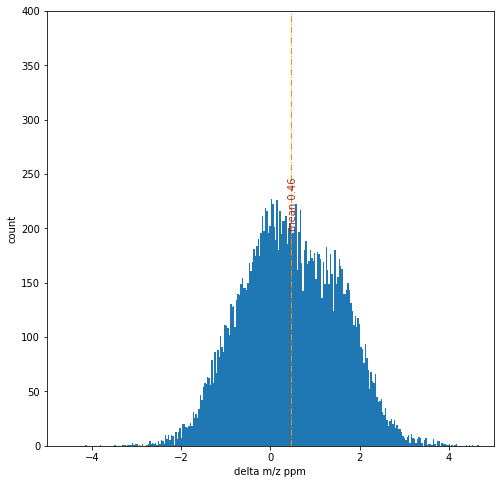

In [9]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)

plt.margins(0.06)
plt.title('')

bins = 300
values = tfde_trimmed_df.mean_mass_error_ppm
y, x, _ = ax1.hist(values, bins=bins)

mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('delta m/z ppm')
plt.ylabel('count')

plt.xlim((-5,5))
plt.ylim((0,400))

# plt.title('delta between extracted and theoretical monoisotopic m/z ppm\nexperiment {}'.format(EXPERIMENT_NAME))

plt.show()

#### MaxQuant

In [10]:
MQ_RESULTS_DIR = '{}'.format(expanduser('~'))
# MQ_RESULTS_DIR = '{}/Downloads/experiments'.format(expanduser('~'))
mq_results_df = pd.read_csv('{}/MQ-analysis-of-P3856/combined/txt/evidence.txt'.format(MQ_RESULTS_DIR), sep='\\t', engine='python')

In [11]:
# remove decoys, which are indicated by a '+' in the Reverse column
mq_results_df = mq_results_df[pd.isna(mq_results_df.Reverse)]
# remove identifications with no intensity
mq_results_df = mq_results_df[(mq_results_df.Intensity > 0)]
# remove potential contaminants
mq_results_df = mq_results_df[pd.isna(mq_results_df['Potential contaminant'])]
# remove identifications with mass error more than +/- 5 ppm
mq_results_df = mq_results_df[np.abs(mq_results_df['Mass error [ppm]']) <= 5.0]
# add RT as seconds
mq_results_df['retention_time_secs'] = mq_results_df['Retention time']*60.0

In [12]:
# definition of uniqueness in MaxQuant output with MBR on
unique_peptide_key = ['Sequence','Modifications','Charge']

In [13]:
mq_results_df.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Type',
       'Raw file', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'Calibrated CCS', 'CCS length', 'Match time difference',
       'Match m/z difference', 'Match K0 difference', 'Match q-value',
       'M

In [14]:
# get one reading for each unique peptide in each run, and count how many identifications and extractions (i.e. 
# matches) across each group. Note that a sequence can be counted as an identification and a match in the same file 
# (i.e. it's given a different score).
mq_sequences_l = []
unique_peptide_key_file = unique_peptide_key + ['Raw file']
for group_name,group_df in mq_results_df.groupby(unique_peptide_key_file, as_index=False):
    short_run_name = '_'.join(group_name[3].split('_Slot')[0].split('_')[1:3])
    grp_name = short_run_name.split('_')[0]
    if grp_name == 'YHE211':
        sorted_df = group_df.sort_values(by=['Intensity'], ascending=False, inplace=False)
        mass_error_ppm = sorted_df.iloc[0]['Mass error [ppm]']
        mq_sequences_l.append({'Sequence':group_name[0], 'Modifications':group_name[1], 'Charge':group_name[2], 'run_name':short_run_name, 'mass_error_ppm':mass_error_ppm})
mq_sequences_df = pd.DataFrame(mq_sequences_l)

In [15]:
# summarise the extractions
extractions_l = []
for group_name,group_df in mq_sequences_df.groupby(unique_peptide_key, as_index=False):
    number_of_runs = len(group_df.run_name.unique())
    mean_mass_error_ppm = group_df.mass_error_ppm.mean()
    extractions_l.append({'sequence':group_name[0],'mod':group_name[1],'charge':group_name[2],'mean_mass_error_ppm':mean_mass_error_ppm,'number_of_runs':number_of_runs})
mq_extractions_df = pd.DataFrame(extractions_l)

In [16]:
mq_extractions_df

,sequence,mod,charge,mean_mass_error_ppm,number_of_runs
0,AAAAAWEEPSSGNGTAR,Unmodified,2,0.181567,5
1,AAAAGAAAAAAAEGEAPAEMGALLLEK,Acetyl (Protein N-term),3,0.346348,10
2,AAAAGGGGPGTAVGATGSGIAAAAAGLAVYR,Acetyl (Protein N-term),3,1.535574,10
3,AAAAKPNNLSLVVHGPGDLR,Acetyl (Protein N-term),3,-1.784242,10
4,AAAANSGSSLPLFDCPTWAGKPPPGLHLDVVK,Acetyl (Protein N-term),3,-1.615109,8
...,...,...,...,...,...
18331,YYTGNYDQYVK,Unmodified,2,2.237377,6
18332,YYTSASGDEMVSLK,Unmodified,2,0.647507,10
18333,YYVPEDPSQDADYDVSAK,Unmodified,2,1.306444,7
18334,YYVTIIDAPGHR,Unmodified,2,1.307585,10


In [17]:
mq_trimmed_df = mq_extractions_df[mq_extractions_df.mean_mass_error_ppm <= 5]

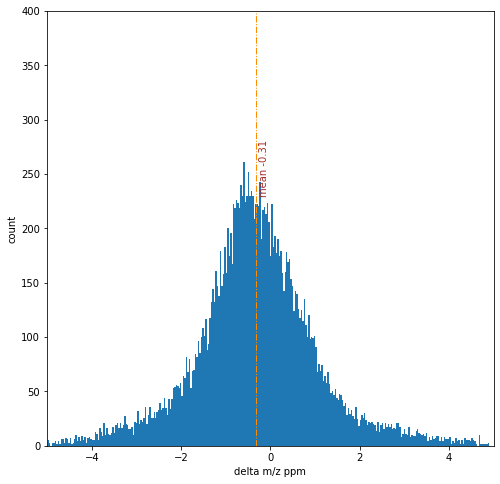

In [18]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)

plt.margins(0.06)
plt.title('')

bins = 300
values = mq_trimmed_df.mean_mass_error_ppm
y, x, _ = ax1.hist(values, bins=bins)

mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('delta m/z ppm')
plt.ylabel('count')

plt.xlim((-5,5))
plt.ylim((0,400))

# plt.title('delta between extracted and theoretical monoisotopic m/z ppm\nexperiment {}'.format(EXPERIMENT_NAME))

plt.show()

#### MSFragger (identifications only; mass error for MBR is not reported)

In [19]:
FRAGGER_RESULTS_DIR = '{}'.format(expanduser('~'))
# FRAGGER_RESULTS_DIR = '{}/Downloads/experiments'.format(expanduser('~'))
fragger_stats_df = pd.read_csv('{}/MSFragger-analysis-P3856/MSstats-P3856.csv'.format(FRAGGER_RESULTS_DIR), sep=',')

In [20]:
fragger_stats_df = fragger_stats_df[fragger_stats_df.Intensity.notnull()]
fragger_stats_df = fragger_stats_df[fragger_stats_df.Condition == 'YHE211']

In [21]:
fragger_stats_df.sample(n=4)

,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity
762952,sp|Q9Y5K8|VATD_HUMAN,FTAGDFSTTVIQNVNK,2,NaN,NaN,L,YHE211,2,P3856_YHE211_2_Slot1-1_1_5105,15269.682
405207,sp|P62277|RS13_HUMAN,GLTPSQIGVLLR,2,NaN,NaN,L,YHE211,7,P3856_YHE211_7_Slot1-1_1_5110,14592.588
655588,sp|Q9BRP1|PDD2L_HUMAN,n[42.0106]AAVLKPVLLGLR,2,NaN,NaN,L,YHE211,8,P3856_YHE211_8_Slot1-1_1_5111,27133.123
686185,sp|Q9H9J2|RM44_HUMAN,NLVDFLTGEEVVC[57.0215]HVAR,2,NaN,NaN,L,YHE211,5,P3856_YHE211_5_Slot1-1_1_5108,45540.453


In [23]:
FRAGGER_RESULTS_DIR = '{}/MSFragger-analysis-P3856/with-MBR/P3856-results'.format(expanduser('~'))
dir_l = glob.glob('{}/YHE211_*'.format(FRAGGER_RESULTS_DIR))
df_l = []
for f in dir_l:
    df = pd.read_csv('{}/psm.tsv'.format(f), sep='\\t', engine='python')
    df_l.append(df)
fragger_mass_df = pd.concat(df_l, axis=0, sort=False, ignore_index=True)

In [24]:
fragger_mass_df.columns

Index(['Spectrum', 'Spectrum File', 'Peptide', 'Modified Peptide',
       'Peptide Length', 'Charge', 'Retention', 'Observed Mass',
       'Calibrated Observed Mass', 'Observed M/Z', 'Calibrated Observed M/Z',
       'Calculated Peptide Mass', 'Calculated M/Z', 'Delta Mass',
       'Expectation', 'Hyperscore', 'Nextscore', 'PeptideProphet Probability',
       'Number of Enzymatic Termini', 'Number of Missed Cleavages',
       'Intensity', 'Ion Mobility', 'Assigned Modifications',
       'Observed Modifications', 'Is Unique', 'Protein', 'Protein ID',
       'Entry Name', 'Gene', 'Protein Description', 'Mapped Genes',
       'Mapped Proteins'],
      dtype='object')

In [25]:
fragger_mass_df['Run'] = fragger_mass_df.apply(lambda row: row['Spectrum'].split('.')[0], axis=1)
fragger_mass_df['PeptideSequence'] = fragger_mass_df.apply(lambda row: row['Peptide'] if str(row['Modified Peptide']) == 'nan' else row['Modified Peptide'], axis=1)
fragger_mass_df.rename({'Charge':'PrecursorCharge'}, axis=1, inplace=True)

In [26]:
fragger_mass_df.head()

,Spectrum,Spectrum File,Peptide,Modified Peptide,Peptide Length,PrecursorCharge,Retention,Observed Mass,Calibrated Observed Mass,Observed M/Z,...,Is Unique,Protein,Protein ID,Entry Name,Gene,Protein Description,Mapped Genes,Mapped Proteins,Run,PeptideSequence
0,P3856_YHE211_9_Slot1-1_1_5112.00396.00396.2,D:\P3856-results\YHE211_9\interact.pep.xml,RAASNMALGK,RAASNM[147]ALGK,10,2,197.146,1033.5233,1033.5247,517.7689,...,True,sp|P53041|PPP5_HUMAN,P53041,PPP5_HUMAN,PPP5C,Serine/threonine-protein phosphatase 5,None,None,P3856_YHE211_9_Slot1-1_1_5112,RAASNM[147]ALGK
1,P3856_YHE211_9_Slot1-1_1_5112.00571.00571.2,D:\P3856-results\YHE211_9\interact.pep.xml,RNEDEDSPNK,NaN,10,2,296.900,1202.5103,1202.5142,602.2624,...,True,sp|P62899|RL31_HUMAN,P62899,RL31_HUMAN,RPL31,60S ribosomal protein L31,None,None,P3856_YHE211_9_Slot1-1_1_5112,RNEDEDSPNK
2,P3856_YHE211_9_Slot1-1_1_5112.00575.00575.2,D:\P3856-results\YHE211_9\interact.pep.xml,RNEDEDSPNK,NaN,10,2,299.000,1202.5160,1202.5198,602.2653,...,True,sp|P62899|RL31_HUMAN,P62899,RL31_HUMAN,RPL31,60S ribosomal protein L31,None,None,P3856_YHE211_9_Slot1-1_1_5112,RNEDEDSPNK
3,P3856_YHE211_9_Slot1-1_1_5112.00579.00579.2,D:\P3856-results\YHE211_9\interact.pep.xml,RNEDEDSPNK,NaN,10,2,301.101,1202.5133,1202.5172,602.2639,...,True,sp|P62899|RL31_HUMAN,P62899,RL31_HUMAN,RPL31,60S ribosomal protein L31,None,None,P3856_YHE211_9_Slot1-1_1_5112,RNEDEDSPNK
4,P3856_YHE211_9_Slot1-1_1_5112.00588.00588.2,D:\P3856-results\YHE211_9\interact.pep.xml,RNEDEDSPNK,NaN,10,2,305.302,1202.5134,1202.5173,602.2640,...,True,sp|P62899|RL31_HUMAN,P62899,RL31_HUMAN,RPL31,60S ribosomal protein L31,None,None,P3856_YHE211_9_Slot1-1_1_5112,RNEDEDSPNK


In [27]:
fragger_mass_df['Delta Mass ppm'] = (fragger_mass_df['Calibrated Observed Mass'] - fragger_mass_df['Calculated Peptide Mass']) / fragger_mass_df['Calculated Peptide Mass'] * 1e6

In [29]:
fragger_mass_df.columns

Index(['Spectrum', 'Spectrum File', 'Peptide', 'Modified Peptide',
       'Peptide Length', 'PrecursorCharge', 'Retention', 'Observed Mass',
       'Calibrated Observed Mass', 'Observed M/Z', 'Calibrated Observed M/Z',
       'Calculated Peptide Mass', 'Calculated M/Z', 'Delta Mass',
       'Expectation', 'Hyperscore', 'Nextscore', 'PeptideProphet Probability',
       'Number of Enzymatic Termini', 'Number of Missed Cleavages',
       'Intensity', 'Ion Mobility', 'Assigned Modifications',
       'Observed Modifications', 'Is Unique', 'Protein', 'Protein ID',
       'Entry Name', 'Gene', 'Protein Description', 'Mapped Genes',
       'Mapped Proteins', 'Run', 'PeptideSequence', 'Delta Mass ppm'],
      dtype='object')

In [30]:
fragger_sequences_l = []
for group_name,group_df in fragger_mass_df.groupby(['PeptideSequence','PrecursorCharge','Run'], as_index=False):
    sorted_df = group_df.sort_values(by=['Intensity'], ascending=False, inplace=False)
    mass_error_ppm = sorted_df.iloc[0]['Delta Mass ppm']
    fragger_sequences_l.append({'PeptideSequence':group_name[0], 'PrecursorCharge':group_name[1], 'Run':group_name[2], 'mass_error_ppm':mass_error_ppm})
fragger_sequences_df = pd.DataFrame(fragger_sequences_l)

In [41]:
len(fragger_stats_df), len(fragger_sequences_df)

(154800, 125136)

In [32]:
fragger_results_df = pd.merge(fragger_stats_df, fragger_sequences_df, how='inner', left_on=['Run','PeptideSequence','PrecursorCharge'], right_on=['Run','PeptideSequence','PrecursorCharge'])

In [33]:
fragger_results_df.head()

,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity,mass_error_ppm
0,sp|A0A0B4J2D5|GAL3B_HUMAN,GVEVTVGHEQEEGGK,2,NaN,NaN,L,YHE211,10,P3856_YHE211_10_Slot1-1_1_5113,16679.225,-0.579250
1,sp|A0A0B4J2D5|GAL3B_HUMAN,GVEVTVGHEQEEGGK,2,NaN,NaN,L,YHE211,1,P3856_YHE211_1_Slot1-1_1_5104,17801.191,-2.381363
2,sp|A0A0B4J2D5|GAL3B_HUMAN,GVEVTVGHEQEEGGK,2,NaN,NaN,L,YHE211,2,P3856_YHE211_2_Slot1-1_1_5105,17984.355,0.514889
3,sp|A0A0B4J2D5|GAL3B_HUMAN,GVEVTVGHEQEEGGK,2,NaN,NaN,L,YHE211,3,P3856_YHE211_3_Slot1-1_1_5106,14508.194,0.450528
4,sp|A0A0B4J2D5|GAL3B_HUMAN,GVEVTVGHEQEEGGK,2,NaN,NaN,L,YHE211,4,P3856_YHE211_4_Slot1-1_1_5107,21444.799,1.094140


In [34]:
fragger_unique_peptide_key = ['PeptideSequence','PrecursorCharge']

In [35]:
# summarise the extractions
extractions_l = []
for group_name,group_df in fragger_results_df.groupby(fragger_unique_peptide_key, as_index=False):
    number_of_runs = len(group_df['Run'].unique())
    mean_mass_error_ppm = group_df.mass_error_ppm.mean()
    extractions_l.append({'sequence':group_name[0],'charge':group_name[1],'mean_mass_error_ppm':mean_mass_error_ppm,'number_of_runs':number_of_runs})
fragger_extractions_df = pd.DataFrame(extractions_l)

In [36]:
fragger_extractions_df

,sequence,charge,mean_mass_error_ppm,number_of_runs
0,AAAAAWEEPSSGNGTAR,2,-0.349597,4
1,AAAEELQEAAGAGDGATENGVQPPK,2,-2.142755,1
2,AAAEGVANLHLDEATGEMVSK,2,-0.544504,10
3,AAAEIYEEFLAAFEGSDGNK,2,51.807286,9
4,AAAEIYEEFLAAFEGSDGNK,3,-0.526624,9
...,...,...,...,...
14610,YYTFNGPNYNENETIR,2,-0.310951,10
14611,YYTGNYDQYVK,2,-1.911336,1
14612,YYTSASGDEMVSLK,2,7.033633,10
14613,YYVPEDPSQDADYDVSAK,2,1.188810,2


In [37]:
fragger_trimmed_df = fragger_extractions_df[np.abs(fragger_extractions_df.mean_mass_error_ppm) <= 5]

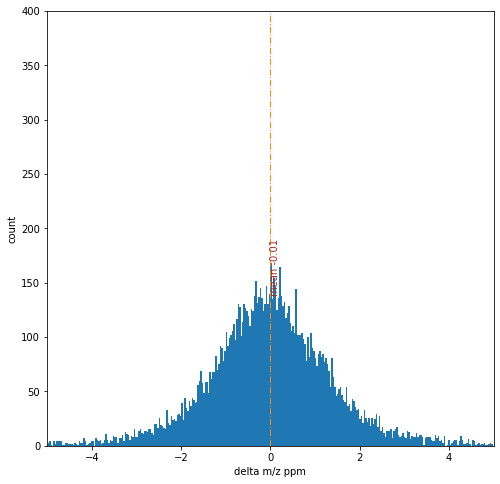

In [39]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)

plt.margins(0.06)
plt.title('')

bins = 300
values = fragger_trimmed_df.mean_mass_error_ppm
y, x, _ = ax1.hist(values, bins=bins)

mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('delta m/z ppm')
plt.ylabel('count')

plt.xlim((-5,5))
plt.ylim((0,400))

# plt.title('delta between extracted and theoretical monoisotopic m/z ppm\nexperiment {}'.format(EXPERIMENT_NAME))

plt.show()